In [1]:
import os
import glob
import csv
from collections import Counter, defaultdict
import pandas as pd
import numpy as np

import omop_analyze
import s4s_analyze

original_path = os.getcwd()

def omop_formatted(tables):
    return {filename: len(table) for filename, table in tables.items()}
    
def s4s_formatted(counts):
    return {k: len(v) for k, v in counts.items()}

def filter_matches(omop_tables, s4s_uniques):
    return filter_procedures(omop_tables, s4s_uniques)

def filter_procedures(omop_tables, s4s_uniques):
    return omop_tables, s4s_uniques

def csv_to_dicts(filename):
    with open(filename, encoding="utf8") as csv_file:
        items = (filename, list(csv.DictReader(csv_file, delimiter="\t")))
    return items

In [2]:
vocab = csv_to_dicts('VOCABULARY.csv')[1]
vocab_df = pd.DataFrame(vocab)
concept = csv_to_dicts('CONCEPT.csv')[1]
concept_df = pd.DataFrame(concept)

In [3]:
s4s_people = {}
total_counts = defaultdict(lambda: defaultdict(list))      
search_path = os.path.join(original_path, 'fhir', 'Participant', '*', 'SyncForScience')
for directory in glob.glob(search_path):
    base_uri, dir_counts = s4s_analyze.data_in_directory(directory)
    person_id = directory.split('\\')[-2][1:]
    s4s_people[person_id] = dir_counts
print("got {} s4s participants".format(len(s4s_people.keys())))

got 83 s4s participants


In [4]:
##### S4S Data #####
# Histogram showing counts for each data category, across the population. E.g., how many patients with 0 Conditions; 1-10; etc. (Ranges will be determined by the actual data distribution.)

s4s_datatype_totals = {person:{title:len(items) for (title, items) in datatype.items()} for (person, datatype) in s4s_people.items()}
s4s_df = pd.DataFrame(s4s_datatype_totals).transpose()

s4s_df.plot(kind='box', figsize=(20,6), logy=True)

In [5]:
# Count of code *systems* for each data category. E.g., fraction of SNOMED vs LOINC vs Other codes found in Conditions.
s4s_coding_per_category = {person:{category:[item['code']['coding'] for item in items if 'code' in item.keys() and 'coding' in item['code']] for (category, items) in categories.items()} for (person, categories) in s4s_people.items()}
s4s_systems_per_category = {person:{category:sum([[code['system'] for code in item if 'system' in code] for item in items if item], []) for (category, items) in category.items()} for (person, category) in s4s_coding_per_category.items()}
s4s_codes_per_category = {person:{category:sum([[code['code'] for code in item if 'code' in code] for item in items if item], []) for (category, items) in category.items()} for (person, category) in s4s_coding_per_category.items()}

In [6]:
# Top N standardized codes for each data category. E.g., what were the top 10 Conditions?
# Count of valid vs invalid codes for each data category. E.g. how many valid Condition codes, how many invalid, and how many missing?
# Distribution of number of Codings present in CodeableConcepts for each data category. I.e., how often were translation codes supplied for Conditions?

In [7]:
# Complete "tree" of FHIR paths for each data category. E.g., for Condition, which JSON elements (and sub elements, and so on, recursively) are present?
class Node:
    def __init__():
        count = Counter()
        

def traverse_fhir_json(obj):
    #string - leaf node
    #number - leaf node
    #dict - add node per key
    #list - add node per item
    #True False - leaf node
    #None. - leaf node
    pass


In [8]:
# Same "tree" of FHIR paths as above, with each node annotated by count. E.g., for Condition.code.coding[0].system, how many times was this path present?
# For each status flag, what is the distribution of values? E.g., for Condition.clinicalStatus, how often is the value active | relapse | remission | resolved?

In [9]:
omop_dump = omop_analyze.data_dump()
# combine observation_1 and observation_2
# tables['observation.csv'] = 
omop_tables = {}
for key, value in dict(omop_dump).items():
    if key == 'observation_1.csv':
        omop_tables['observation.csv'] = value[1]
    elif key == 'observation_2.csv':
        if 'observation.csv' in omop_tables:
            omop_tables['observation.csv'] += value[1]
        else:
            omop_tables['observation.csv'] = value[1]
    else:
        omop_tables[key] = value[1]
omop_tables.keys()

['condition.csv', 'observation_1.csv', 'observation_2.csv', 'procedure.csv']


dict_keys(['condition.csv', 'observation.csv', 'procedure.csv'])

In [10]:
omop_data_types = ['condition', 'observation', 'procedure']
omop_people = omop_analyze.parse_omop()
#combine observation_1 and observation_2
for person, data_types in omop_people.items():
    if 'observation_1.csv' in data_types.keys():
        data_types['observation.csv'] = data_types['observation_1.csv']
        del data_types['observation_1.csv']
        if 'observation_2.csv' in data_types.keys():
            data_types['observation.csv'].append(data_types['observation_2.csv'])
            del data_types['observation_2.csv']
    elif 'observation_2.csv' in data_types.keys():
        data_types['observation.csv'] = data_types['observation_2.csv']
        del data_types['observation_2.csv']
print("Got {} omop participants".format(len(omop_people.keys())))

['condition.csv', 'observation_1.csv', 'observation_2.csv', 'procedure.csv']
Got 72 omop participants


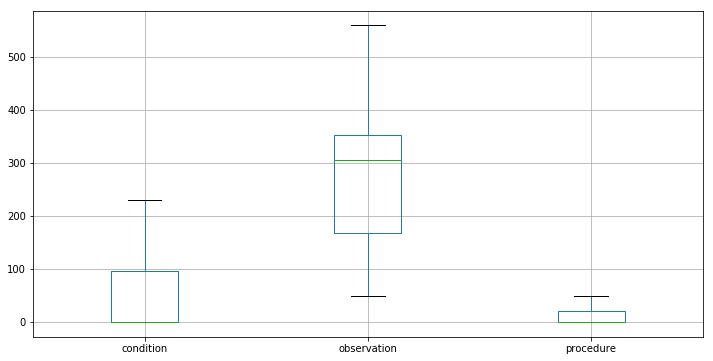

In [11]:
# Histogram showing counts for each OMOP data type, across the population. E.g., how many patients with 0 Conditions; 1-10; etc. (Ranges will be determined by the actual data distribution.)
omop_data_types_per_person = {data_type: [len(person[data_type+'.csv']) if data_type+'.csv' in person.keys() else 0 for person in omop_people.values()] for data_type in omop_data_types}
omop_df_types = pd.DataFrame(omop_data_types_per_person, index=omop_people.values())
omop_df_types.boxplot(figsize=(12,6), showfliers=False)

In [12]:
# Count of standardized code *systems* for each OMOP data type. E.g., fraction of SNOMED vs LOINC vs Other codes found in condition_concept_id.
vocabulary_sources = Counter()
for person, tables in omop_people.items():
    for filename, incidents in tables.items():
        for incident in incidents:
            vocabulary_sources[filename + '-' + incident['source_vocabulary']] += 1

vocabulary_sources

Counter({'condition.csv-ICD10CM': 7212,
         'condition.csv-ICD9CM': 4051,
         'procedure.csv-CPT4': 1287,
         'observation.csv-PPI': 9013,
         'observation.csv-None': 12106,
         'procedure.csv-ICD10CM': 186,
         'procedure.csv-ICD10PCS': 202,
         'procedure.csv-ICD9CM': 225,
         'observation.csv-ICD10CM': 147,
         'procedure.csv-ICD9Proc': 97,
         'observation.csv-ICD9CM': 206,
         'procedure.csv-HCPCS': 23})

In [13]:
# Count of non-standardized code *systems* for each OMOP data type. E.g., fraction of SNOMED vs LOINC vs Other codes found in condition_source_concept_id

In [14]:
# Top N standardized codes for each data category. E.g., what were the top 10 Conditions?


In [15]:
# For each OMOP column, how often was a value present vs absent?
procedure_df = pd.DataFrame(omop_tables['procedure.csv'])
print("Number of rows: ", len(procedure_df))
procedure_columns = set(procedure_df.columns) - {
    'person_id',
    'procedure_date',
    'procedure_datetime',
    'procedure_occurrence_id'
}
for column in procedure_columns:
    print(procedure_df[column].value_counts()[:3])

Number of rows:  2020
36415    154
99214     85
99213     69
Name: source_code_structured, dtype: int64
2108115    154
2414398     85
2414397     69
Name: procedure_source_concept_id, dtype: int64
4000000000181312    10
4000000000178509     9
4000000000169699     9
Name: visit_occurrence_id, dtype: int64
1    1582
      438
Name: quantity, dtype: int64
2108115    154
2414398     85
2414397     69
Name: procedure_concept_id, dtype: int64
CPT4        1287
ICD9CM       225
ICD10PCS     202
Name: source_vocabulary, dtype: int64
0           1337
44786630     683
Name: procedure_type_concept_id, dtype: int64
0    1582
      438
Name: provider_id, dtype: int64
         272
36415    154
99214     85
Name: procedure_source_value, dtype: int64
cpmc_ceders    1582
nec_phs         438
Name: src_hpo_id, dtype: int64
            1439
0            438
42739576      53
Name: modifier_concept_id, dtype: int64
    2020
Name: qualifier_source_value, dtype: int64


In [16]:
print(
    "Number of found procedure_concept_ids in concept table: ",
    len(concept_df.loc[concept_df['concept_id'].isin(procedure_df['procedure_concept_id'])])
)
print(
    "Total number of procedure_concept_ids: ",
    len(procedure_df['procedure_concept_id'].value_counts())
)
missing_procedures = set(procedure_df['procedure_concept_id']) - set(concept_df['concept_id'])

Number of found procedure_concept_ids in concept table:  93
Total number of procedure_concept_ids:  340


In [17]:
observation_df = pd.DataFrame(omop_tables['observation.csv'])
print("Number of rows: ", len(observation_df))
observation_columns = set(observation_df.columns) - {
    'observation_id',
    'person_id',
    'observation_date',
    'observation_datetime',
}
for column in observation_columns:
    print(observation_df[column].value_counts()[:3])

Number of rows:  21472
       20908
2.0      251
0.0       91
Name: value_as_number, dtype: int64
0         9999
903096    3758
          3007
Name: value_source_concept_id, dtype: int64
0           9807
903096      3758
45878245     639
Name: value_as_concept_id, dtype: int64
             3020
807029061     182
914381877     132
Name: questionnaire_response_id, dtype: int64
None      12106
PPI        9013
ICD9CM      206
Name: source_vocabulary, dtype: int64
     21119
0      353
Name: provider_id, dtype: int64
0    18465
      3007
Name: qualifier_concept_id, dtype: int64
0          9455
4041306    2654
1586155     139
Name: observation_concept_id, dtype: int64
rdr            18465
cpmc_ceders     2654
nec_phs          353
Name: src_hpo_id, dtype: int64
    21472
Name: unit_source_value, dtype: int64
0    18465
      3007
Name: unit_concept_id, dtype: int64
No matching concept                   12106
White_WhiteSpecific                     139
RecreationalDrugUse_WhichDrugsUsed      

In [18]:
print(
    "Number of found observation_concept_ids in concept table: ",
    len(concept_df.loc[concept_df['concept_id'].isin(observation_df['observation_concept_id'])])
)
print(
    "Total number of observation_concept_ids: ",
    len(observation_df['observation_concept_id'].value_counts())
)
missing_observations = set(observation_df['observation_concept_id']) - set(concept_df['concept_id'])
observation_df[observation_df['observation_concept_id'].isin(missing_observations)]
missing_observations

Number of found observation_concept_ids in concept table:  66
Total number of observation_concept_ids:  215


{'1585246',
 '1585247',
 '1585248',
 '1585249',
 '1585250',
 '1585252',
 '1585259',
 '1585260',
 '1585344',
 '1585348',
 '1585357',
 '1585370',
 '1585475',
 '1585477',
 '1585480',
 '1585481',
 '1585482',
 '1585483',
 '1585484',
 '1585485',
 '1585486',
 '1585487',
 '1585488',
 '1585489',
 '1585490',
 '1585491',
 '1585492',
 '1585494',
 '1585495',
 '1585498',
 '1585501',
 '1585504',
 '1585507',
 '1585510',
 '1585514',
 '1585527',
 '1585532',
 '1585551',
 '1585552',
 '1585576',
 '1585596',
 '1585597',
 '1585598',
 '1585636',
 '1585647',
 '1585650',
 '1585656',
 '1585668',
 '1585674',
 '1585680',
 '1585686',
 '1585698',
 '1585704',
 '1585766',
 '1585772',
 '1585778',
 '1585789',
 '1585795',
 '1585796',
 '1585802',
 '1585803',
 '1585806',
 '1585811',
 '1585815',
 '1585820',
 '1585838',
 '1585845',
 '1585850',
 '1585865',
 '1585866',
 '1585871',
 '1585878',
 '1585879',
 '1585886',
 '1585889',
 '1585890',
 '1585892',
 '1585899',
 '1585907',
 '1585908',
 '1585909',
 '1585910',
 '1585911',
 '15

In [19]:
# For each OMOP column, how often was a value present vs absent?
condition_df = pd.DataFrame(omop_tables['condition.csv'])
print("Number of rows: ", len(condition_df))
condition_columns = set(condition_df.columns) - {
    'person_id',
    'condition_start_date',
    'condition_start_datetime',
    'condition_end_date',
    'condition_end_datetime',
    'condition_occurrence_id'
}
for column in condition_columns:
    print(condition_df[column].value_counts()[:3])

Number of rows:  11263
C50.912    610
C79.51     404
C50.919    396
Name: source_code_structured, dtype: int64
      10898
AD      365
Name: condition_status_source_value, dtype: int64
ICD10CM    7212
ICD9CM     4051
Name: source_vocabulary, dtype: int64
0    6545
     4718
Name: provider_id, dtype: int64
45556996    610
45552285    404
45600511    396
Name: condition_source_concept_id, dtype: int64
cpmc_ceders    6545
nec_phs        4718
Name: src_hpo_id, dtype: int64
137809     872
4157332    506
0          495
Name: condition_concept_id, dtype: int64
0           6180
4203942      365
44821787     144
Name: condition_status_concept_id, dtype: int64
    11263
Name: stop_reason, dtype: int64
C50.912    610
C79.51     404
C50.919    396
Name: condition_source_value, dtype: int64
4000000000023113    45
4000000000027131    43
4000000000030830    43
Name: visit_occurrence_id, dtype: int64
0           4514
44786629    4284
44786627    2465
Name: condition_type_concept_id, dtype: int64


In [20]:
print(
    "Number of found condition_concept_ids in concept table: ",
    len(concept_df.loc[concept_df['concept_id'].isin(condition_df['condition_concept_id'])])
)
print(
    "Total number of condition_concept_ids: ",
    len(condition_df['condition_concept_id'].value_counts())
)

Number of found condition_concept_ids in concept table:  775
Total number of condition_concept_ids:  775


In [21]:
# for person, tables in omop_people_stats.items():
#     # print("OMOP: {}\nMatching S4S: {}\n".format(omop_formatted(tables), s4s_formatted(s4s_people_stats[person])))
#     print("Patient: {}\n{}\n".format(person, filter_procedures(tables, s4s_people_stats[person])))

In [22]:
##### Comparing OMOP to S4S #####
# Draw a distribution of "total # data elements in OMOP vs S4S" for each data category. E;g., each patient would contribute one dot to a Condition Count histogram by taking (# S4S Conditions - # OMOP conditions), which will be a positive number if more S4S conditions, and a negative number of more OMOP conditions.
# TODO (how to specify): show which values appeared in S4S but not OMOP, and vice versa.
# TODO: after early exploration, what else do we want to evaluate?
